In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DEML(nn.Module):
    def __init__(self, num_genes, l1_lambda=0.01):
        super(DEML, self).__init__()
        self.linear = nn.Linear(num_genes, 1)
        self.l1_lambda = l1_lambda

    def forward(self, x):
        logits = self.linear(x)
        probs = torch.sigmoid(logits)
        return probs

    def l1_regularization(self):
        return torch.norm(self.linear.weight, p=1)

    def compute_loss(self, y_pred, y_true):
        bce_loss = F.binary_cross_entropy(y_pred, y_true)
        l1_loss = self.l1_lambda * self.l1_regularization()
        return bce_loss + l1_loss

    def get_gene_importance(self):
        return self.linear.weight.detach().cpu().numpy().flatten()


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc

from sklearn.linear_model import RidgeClassifier, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Load data
#mydata = 'GSE64810'
mydata = 'combined'
data_file = './data/'+ mydata +'.csv'
degs_file = './data/' + mydata + '_DEGS.txt'
out_file = './results/fs_scores64810_LSVC.csv'

# Read dataset
#df = pd.read_csv(data_file)
df = pd.read_csv(data_file, header=None)  # Read without assuming column headers
df = df.set_index(0).T  # Set first column as header and transpose
df.columns.name = None  # Remove index name if needed
df = df.iloc[:, 1:]  
df = df.iloc[:, 1:].reset_index(drop=True)
X = df.drop(columns=['disease'])   # Assuming 'disease' is the label
X.columns = X.columns.astype(str)
y = df['disease'].astype(int)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9104\169007427.py:25: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file, header=None)  # Read without assuming column headers


In [3]:
model = DEML(num_genes=X.shape[1], l1_lambda=0.05)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Ensure all values in X_df are float32
X = X.astype(np.float32)
# Ensure y_df is numeric and has proper shape
y = y.astype(np.float32)

X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values.reshape(-1, 1), dtype=torch.float32)

for epoch in range(200):
    model.train()
    y_pred = model(X_tensor)
    loss = model.compute_loss(y_pred, y_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 4.3594
Epoch 20, Loss: 57.5938
Epoch 40, Loss: 70.9972
Epoch 60, Loss: 64.8315
Epoch 80, Loss: 79.4510
Epoch 100, Loss: 64.4607
Epoch 120, Loss: 78.0431
Epoch 140, Loss: 66.4669
Epoch 160, Loss: 69.5960
Epoch 180, Loss: 69.0567


In [4]:
gene_importance = model.get_gene_importance()
top_genes = sorted(zip(X.columns, gene_importance), key=lambda x: abs(x[1]), reverse=True)
for gene, score in top_genes[:50]:
    print(f"{gene}: {score:.4f}")


Gene_106631781: 0.0221
Gene_378938: 0.0220
Gene_109910380: 0.0217
Gene_109864271: 0.0216
Gene_106631777: 0.0216
Gene_4519: 0.0213
Gene_109864272: 0.0210
Gene_109864282: 0.0210
Gene_109910382: 0.0210
Gene_4512: 0.0209
Gene_4538: 0.0209
Gene_4540: 0.0208
Gene_109910379: 0.0208
Gene_106632264: 0.0204
Gene_109864279: 0.0204
Gene_4508: 0.0204
Gene_100008588: 0.0203
Gene_4549: 0.0202
Gene_100008589: 0.0202
Gene_4550: 0.0201
Gene_4537: 0.0201
Gene_4539: 0.0200
Gene_4514: 0.0200
Gene_4541: 0.0199
Gene_109864280: 0.0199
Gene_2670: 0.0199
Gene_109864273: 0.0198
Gene_4535: 0.0198
Gene_4536: 0.0198
Gene_109136579: 0.0196
Gene_4155: 0.0195
Gene_55384: 0.0191
Gene_112268284: 0.0190
Gene_4513: 0.0190
Gene_3320: 0.0188
Gene_100861532: 0.0188
Gene_1191: 0.0187
Gene_4509: 0.0186
Gene_4567: 0.0185
Gene_4574: 0.0181
Gene_1410: 0.0179
Gene_113219467: 0.0179
Gene_4569: 0.0177
Gene_11170: 0.0175
Gene_222166: 0.0173
Gene_4572: 0.0173
Gene_3303: 0.0173
Gene_28996: 0.0172
Gene_4556: 0.0171
Gene_3337: 0.0171


Epoch 0, Loss: 52.7829
Epoch 20, Loss: 75.4436
Epoch 40, Loss: 56.4513
Epoch 60, Loss: 79.7007
Epoch 80, Loss: 59.4110
Epoch 100, Loss: 60.4917
Epoch 120, Loss: 13.7844
Epoch 140, Loss: 72.6185
Epoch 160, Loss: 54.9851
Epoch 180, Loss: 79.9793


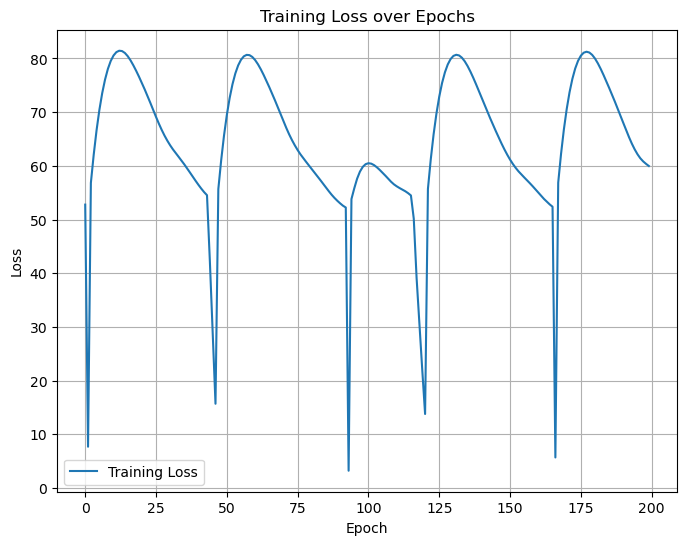

In [5]:
# %% Plot Training Loss
training_losses = []

for epoch in range(200):
    model.train()
    y_pred = model(X_tensor)
    loss = model.compute_loss(y_pred, y_tensor)
    training_losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Plot the training loss over epochs
plt.figure(figsize=(8, 6))
plt.plot(range(200), training_losses, label="Training Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.legend()
plt.show()


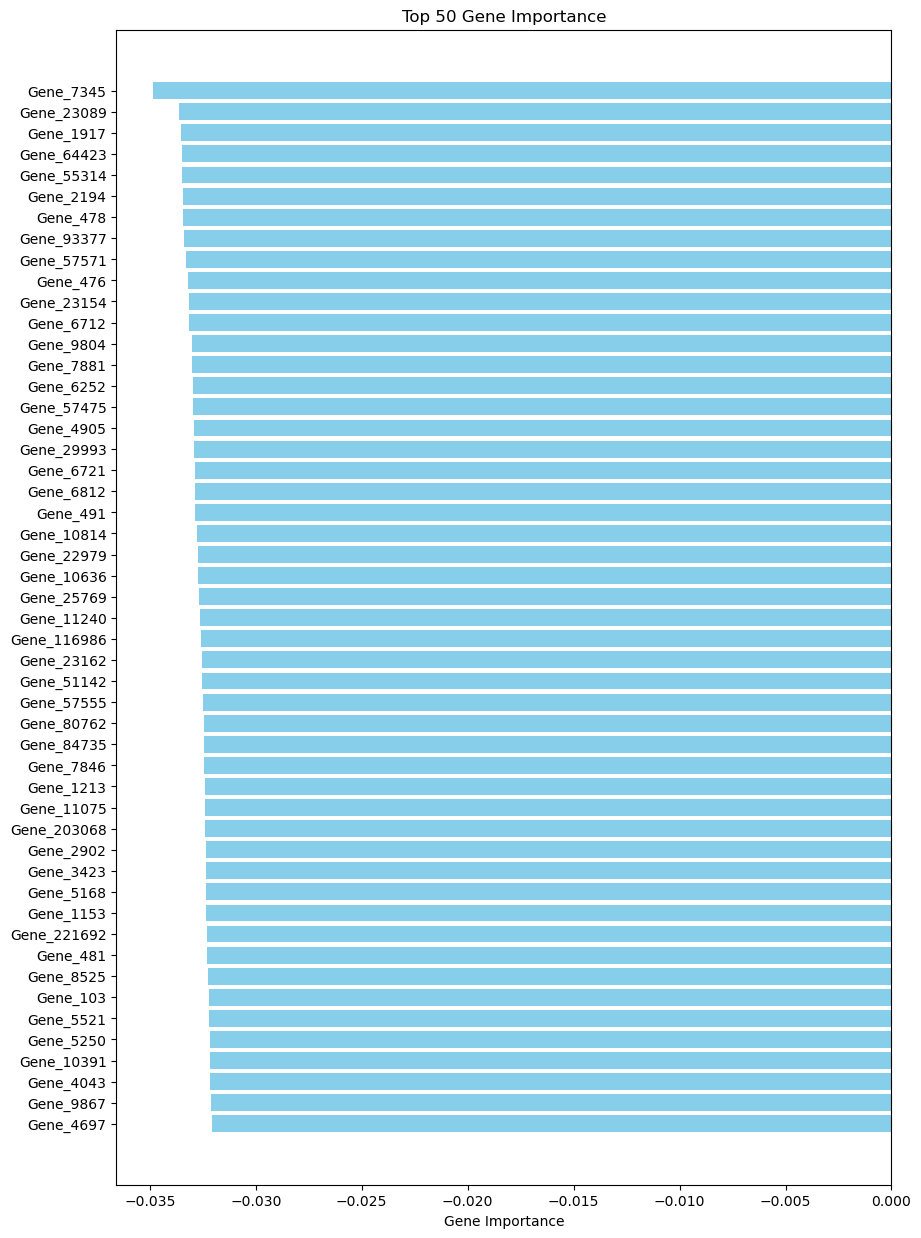

In [6]:
# %% Gene Importance Plot
gene_importance = model.get_gene_importance()
top_genes = sorted(zip(X.columns, gene_importance), key=lambda x: abs(x[1]), reverse=True)

# Get the top 50 genes
top_gene_names = [gene for gene, score in top_genes[:50]]
top_gene_scores = [score for gene, score in top_genes[:50]]

plt.figure(figsize=(10, 15))
plt.barh(top_gene_names, top_gene_scores, color='skyblue')
plt.xlabel('Gene Importance')
plt.title('Top 50 Gene Importance')
plt.gca().invert_yaxis()  # To display the most important gene at the top
plt.show()


In [10]:
tpr

array([0., 1.])

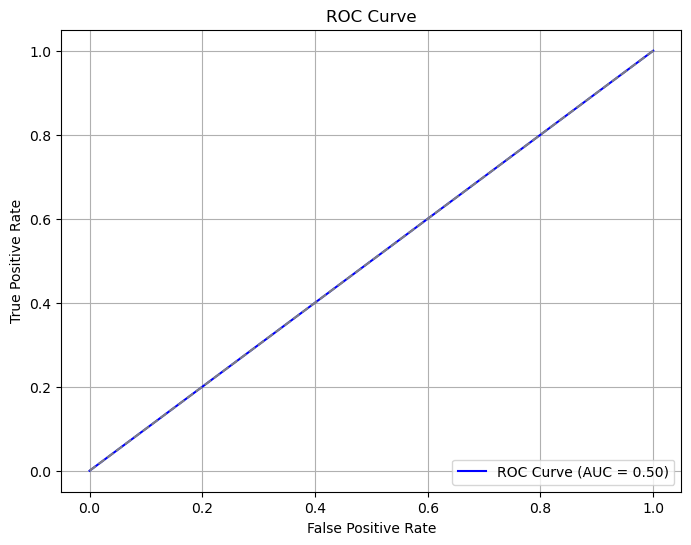

In [7]:
# %% ROC Curve
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

model.eval()
with torch.no_grad():
    y_pred_prob = model(X_test)
    y_pred_prob = y_pred_prob.squeeze()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc_score = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [8]:
# %% Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Convert predictions to binary labels
y_pred_binary = (y_pred_prob >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_binary)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


AttributeError: 'Tensor' object has no attribute 'astype'

In [ ]:
X.shape

(119,)

In [ ]:
# %% Feature Importance from Other Models
models = {
    'Logistic Regression': LogisticRegression(),
    'SVM': LinearSVC(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier()
}

feature_importances = {}

for model_name, model_instance in models.items():
    model_instance.fit(X, y)
    feature_importances[model_name] = model_instance.coef_ if hasattr(model_instance, 'coef_') else model_instance.feature_importances_

# Plot feature importance for comparison
plt.figure(figsize=(12, 6))
for model_name, importance in feature_importances.items():
    plt.plot(X.columns, importance.T, label=model_name)

plt.xlabel('Genes')
plt.ylabel('Feature Importance')
plt.title('Feature Importance Comparison')
plt.legend()
plt.xticks(rotation=90)
plt.show()


ValueError: Expected 2D array, got 1D array instead:
array=[2.714957   2.88467073 3.15049314 3.00986409 3.22178149 2.74808407
 2.68093252 2.61965799 3.13812423 2.74398351 3.18344069 3.05916595
 2.7226131  2.83255243 2.8050468  2.94018292 3.23708415 3.0178709
 3.05636859 2.68230939 2.85641694 2.91700983 2.82022095 2.67859912
 3.14350581 3.20725203 3.43138099 3.10026193 3.21530223 3.07642817
 3.14902997 2.88777733 2.95691943 2.74729586 2.61888909 2.79748702
 2.39350295 2.85637999 3.11080956 2.90317798 2.86109662 3.13736963
 3.12926984 3.0007112  2.84968805 3.35761595 3.32007885 2.80266643
 3.34476018 3.22912931 2.82133007 2.56461763 3.12984538 2.88853312
 3.01233292 2.9563508  2.98434854 2.93171191 3.03685617 3.0956943
 2.57586503 2.51506805 3.21994114 2.77560329 2.96707916 2.8332324
 2.49616361 2.43865561 2.66692185 2.52428269 3.21284628 3.45068669
 2.76032329 2.69276571 3.03735209 2.64294124 2.85133576 2.74631834
 2.76576638 2.63768387 2.4772892  2.58404207 3.03086114 2.68505549
 2.57218075 2.50993443 2.829175   2.67815232 2.94677734 2.77558208
 2.91742659 2.80844116 2.95333004 2.74559212 3.07226753 2.92272735
 2.67088556 2.55935001 3.15233874 2.9211998  3.03645587 3.0826664
 3.07263374 2.9281497  3.10345602 2.800735   3.05368042 2.8312211
 2.52531338 3.13160563 3.12243629 2.81752133 2.90541244 3.05088663
 2.93602467 2.90899372 2.75899386 3.22495103 3.34923363].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.